# Retropropagación en redes profundas

El algoritmo de retropropagación nos permite entrenar una red neuronal sin importar el número de capas que ésta red puede tener. Sin este algoritmo, el aprendizaje profundo no sería posible. De allí su relevancia. 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

## Generación de datos

Pensemos en un problema que originalmente no es linealmente separable. El objetivo es clasificar los puntos en las dos clases que se muestran en la figura.

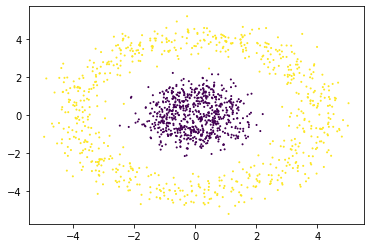

In [2]:
"""
Creación de los datos
"""
r0, r1 = 1, 4
k = 1000
X1 = [np.array([r0*np.cos(t),r0*np.sin(t)]) for t in range(0,k)]
X2 = [np.array([r1*np.cos(t),r1*np.sin(t)]) for t in range(0,k)]
X = np.concatenate((X1,X2))
n,d = X.shape
Y = np.zeros(2*k)
Y[k:] += 1
noise = np.array([np.random.normal(0,1,2) for i in range(n)])
X += 0.5*noise 

#Seprara en train y en test
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

#Visualización de train set
plt.scatter(x_train[:,0], x_train[:,1],c=y_train,s=1)
plt.show()

## Creación de la red profunda

Este problema puede resolverse con una sola capa oculta. De hehco, los teoremas de aproximador universal nos dicen que una sola capa oculta basta para resolver cualquier problema que una red neuronal puede resolver, siempre y cuando se tenga la anchura suficiente en la red.

En la práctica, es común distribuir el cómputo en diversas capas, en lugar de tener una sola capa con una anchura muy grande. En este ejemplo simple, podemos usar una red profunda para solucionar el problema de clasificación. Si bien el ejemplo no requiere de muchas neuronas, podemos ver cómo trabajan las redes profundas. 

Para simplificar la creación de la red neuronal profunda, asumiremos que cada capa tiene el mismo número de neuronas, toda capa oculta se activará con la función <tt>tanh</tt>, para poder simplificar el cálculo de las derivadas.

La red neuronal contará entonces con:

1. Pesos de la capa de entrada hacia la primera capa oculta, que dependerán del tamaño de los datos y de la anchura de la red.
2. $K$ (<tt>n_hidfden</tt>) capas ocultas y sus correspondientes pesos. En este caso, para simplificar, cada capa será de matriz de pesos será de tamaño $width \times width$ donde width es la anchura elegida.
3. Una capa de salida con tantas neuronas de salida como clases.

El esbozo de la clase con el método para computar el forward es el siguiente:

```python
class DeepNN():
    """Clase para entrenar redes neuronales profundas"""
    def __init__(self,n_input,n_output,n_hidden,width):
        super(DeepNN, self).__init__()
        #Pesos capa de entrada
        self.w_in = np.random.rand(n_hidden, n_input)/np.sqrt(n_input)
        self.b_in = np.ones(n_hidden)
        #Pesos para las capas ocultas
        self.w = np.random.rand(width, n_hidden, n_hidden)/np.sqrt(n_input)
        self.b = np.ones((width,n_hidden))
        #Pesos para la capa de salida
        self.w_output = np.random.rand(n_output, n_hidden)/np.sqrt(n_hidden)
        self.b_output = np.ones(n_output)
    
    def __call__(self, x):
        """Aplicación de la red neuronal a datos de entrada"""
        # Guarda las pre-activaciones y activaciones en cada capa
        a = np.zeros((layer_width, number_of_hidden_layers))
        h = np.zeros((layer_width, number_of_hidden_layers))
        for k in range(0, layer_width):
            if k == 0:
                # Capa de entrada
                a[k] = np.dot(self.w_in, x) + self.b_in
                h[k] = np.tanh(a[k])
            else:
                # Capas ocultas
                a[k] = np.dot(self.w[k], h[k-1]) + self.b[k]
                h[k] = np.tanh(a[k])
        
        #Capa de salida
        a_out = np.dot(self.w_output, h[-1]) + self.b_output
        # Función softmax
        tmp = np.exp(a_out)
        f = tmp/tmp.sum(0)
        
        return f
```

In [3]:
# script con el código original
from deep_nerual_net import DeepNN

#Neuronas de entrada
n_input = x_train.shape[1]
#Neuronas en capas ocultas
n_hidden = 3
#Número de capas ocultas
width = 10
#Neuronas de salida
n_output = 2

#Creación de la red neuronal
net = DeepNN(n_input, n_output, n_hidden, width)
#Arquitectura de la red
net.w_shape

(3, 10, 10)

## Entrenamiento con backpropagation

El entrenamiento es la parte más compleja. En el entrenamiento debemos optimizar los pesos con base a una función de riesgo que, en este caso, será la entropía cruzada:

$$R = -\sum_i \delta_{y,i} \ln f_i(x)$$
donde $f_i(x)$ es la $i$-ésima neurona de salida de la red y $\delta_{y,i}$ se define como:

$$\delta_{y,i} = \begin{cases} 1 & \text{si } y=i \\ 
  0 & \text{en otro caso} \end{cases}$$

El algoritmo de backpropagation se determina de la siguiente forma:

![image](imagenes/backprop.png)

Donde, para este caso particular, la variable de salida depende de la entropía cruzada y la activación Softmax, por lo que es:

 $$d_{out}(j) = \frac{\partial R(\theta)}{\partial f_j} \frac{\partial f_j}{\partial a^{(out)}} = f_j - \delta_{y,j}$$
 
Para las capas ocultas, como usamos activación de tangente hiperbólica, las variables de backpropagation son de la forma:

$$d_{k}(j) = \big(1-(h^{(k)})^2\big) \sum_q W^{(k+1)}_{j,q} d_{k+1}(q)$$

Se debe crear un método <tt>train</tt> que calcule estas variables y actualice los pesos por cada capa. el esbozo de este método se presenta a continuación:

```python
def train(self, x_train,y_train, lr=0.01,epochs=100):
    for t in range(epochs):
        for x,y in train_data:
            #FORWARD
            ...

            #BACKWARD
            #Variable en la salida
            d_out = # Derivada de riesgo por derivada de activación en salida
            self.w_output -= lr*np.outer(d_out, h[-1])
            #Variables en las capas ocultas
            d = # Guarda las variables en cada capa oculta
            for k in range(0, number_of_hidden_layers)[::-1]: #Recorre las capas en sentido inverso
                #Se calculan las variables y se actualizan los pesos
                ...
            #Backprop en la capa de entrada
            d_in = # Variable para capa de entrada
            self.w_in -= lr*np.outer(d_in, x)
            self.b_in -= lr*d_in
```

100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


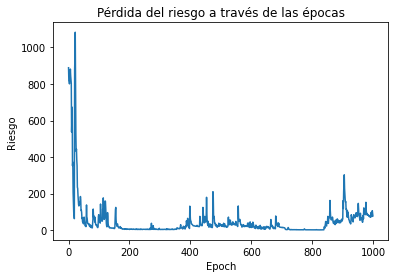

In [4]:
#Rango de aprendizaje
lr = 0.01
#Número de épocas
epochs = 1000

net.train(x_train, y_train, lr=lr, epochs=epochs)

Como se puede observar, el aprendizaje es menos estable, pues se trata de un gran número de capaz para un problema muy simple. En general, en problemas complejos, las redes profundas son muy útiles, pero también suelen requerir un mayor número de épocas para entrenar, además de métodos de regularización, lotes y otro tipo de optimizadores.

### Evaluación

Para finalizar, podemos ver cuál es el desempeño de nuestra red profunda, para esto realizamos la evaluación de la clasificación ya bien conocida por medio del método <tt>classification\_repor</tt> de <tt>sklearn</tt>.

In [5]:
#Predicciones
y_pred = [net(x).argmax() for x in x_test]
#Reporte de clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       302
         1.0       0.98      0.99      0.99       298

    accuracy                           0.98       600
   macro avg       0.99      0.99      0.98       600
weighted avg       0.99      0.98      0.98       600



La evaluación es muy buena porque tenemos una red muy poderosa, en tanto cuenta con un gran número de capas, aplicado a un problema muy simple. De hecho, podríamos pensar que podría darseun sobre-ajuste, pero dado que los datos de entrenamiento representan muy bien los datos de evaluación este sobre-ajuste no se presente. De nuevo, si se trata de un problema más complejo, habría altas posibilidades de sobre-ajuste.

Finalmente, podemos ver las regiones de clasificación de nuestra red profunda:

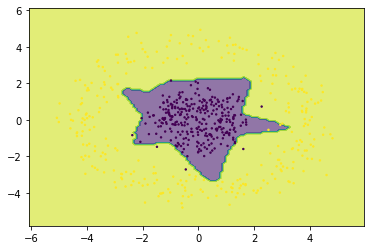

In [6]:
min1, max1 = x_test[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_train[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
yhat = np.array([net(x_i).argmax() for x_i in grid])
zz = yhat.reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.6)

plt.scatter(x_test[:,0], x_test[:,1],c=y_test,s=2)
plt.show()

Si bien, una mayor cantidad de capas muestra mayor capacidad de clasificación; también se puede ver que es más sensible al sobre-ajuste. Por tanto, es recomendable utilizar métodos de regularización que nos ayuden a lidiar con este problema.